# Προεπεξεργασία Δεδομένων Κατανάλωσης Ενέργειας

Αυτό το notebook περιλαμβάνει:
1. Φόρτωση δεδομένων
2. Καθαρισμός (ελλιπείς τιμές, datetime conversion, outliers)
3. Feature Engineering (ημερήσια aggregation, temporal features)
4. Κανονικοποίηση
5. Αποθήκευση καθαρών δεδομένων

In [14]:
# Import βιβλιοθηκών
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
import pickle
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Ρυθμίσεις για καλύτερη οπτικοποίηση
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Βιβλιοθήκες φορτώθηκαν επιτυχώς!")

Βιβλιοθήκες φορτώθηκαν επιτυχώς!


## 1. Φόρτωση Δεδομένων

In [15]:
# Φόρτωση του dataset
print("Φόρτωση δεδομένων...")
df = pd.read_csv('../data/household_power_consumption.txt', 
                 sep=';', 
                 low_memory=False,
                 na_values=['?', 'nan'])

print(f"Διαστάσεις dataset: {df.shape}")
print(f"\nΠρώτες γραμμές:")
df.head()

Φόρτωση δεδομένων...
Διαστάσεις dataset: (2075259, 9)

Πρώτες γραμμές:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [16]:
# Πληροφορίες για το dataset
print("Πληροφορίες dataset:")
print(df.info())
print(f"\nΕλλιπείς τιμές ανά στήλη:")
print(df.isnull().sum())
print(f"\nΠοσοστό ελλιπών τιμών:")
print((df.isnull().sum() / len(df) * 100).round(2))

Πληροφορίες dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB
None

Ελλιπείς τιμές ανά στήλη:
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Ποσοστό ελλιπών τιμών:
Date                     0.00
Time                     0.00
Global_ac

## 2. Καθαρισμός Δεδομένων

### 2.1 Μετατροπή Date/Time σε datetime

In [17]:
# Συνδυασμός Date και Time σε ένα datetime column
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                                 format='%d/%m/%Y %H:%M:%S')

# Ορισμός ως index
df.set_index('DateTime', inplace=True)

# Ταξινόμηση κατά χρόνο
df.sort_index(inplace=True)

# Αφαίρεση των παλιών στηλών Date και Time
df.drop(['Date', 'Time'], axis=1, inplace=True)

print(f"Χρονικό εύρος δεδομένων: {df.index.min()} έως {df.index.max()}")
print(f"Διάρκεια: {(df.index.max() - df.index.min()).days} ημέρες")
df.head()

Χρονικό εύρος δεδομένων: 2006-12-16 17:24:00 έως 2010-11-26 21:02:00
Διάρκεια: 1441 ημέρες


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### 2.2 Αντιμετώπιση Ελλιπών Τιμών

In [18]:
# Στατιστικά για ελλιπείς τιμές
print("Ελλιπείς τιμές πριν τον καθαρισμό:")
missing_before = df.isnull().sum()
print(missing_before)
print(f"\nΣυνολικές ελλιπείς τιμές: {df.isnull().sum().sum()}")
print(f"Ποσοστό: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

Ελλιπείς τιμές πριν τον καθαρισμό:
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Συνολικές ελλιπείς τιμές: 181853
Ποσοστό: 1.25%


In [19]:
# Στρατηγική αντιμετώπισης ελλιπών τιμών:
# Επειδή οι μετρήσεις γίνονται ανά λεπτό, θα χρησιμοποιήσουμε forward fill 
# για μικρά κενά και interpolation για μεγαλύτερα

# Forward fill για μικρά κενά (έως 5 λεπτά)
df_filled = df.fillna(method='ffill', limit=5)

# Interpolation για τα υπόλοιπα
df_filled = df_filled.interpolate(method='linear', limit_direction='both')

# Αφαίρεση γραμμών που ακόμα έχουν NaN (αν υπάρχουν)
print(f"\nΕλλιπείς τιμές μετά το filling: {df_filled.isnull().sum().sum()}")

if df_filled.isnull().sum().sum() > 0:
    print(f"Αφαίρεση {df_filled.isnull().any(axis=1).sum()} γραμμών με NaN")
    df_filled = df_filled.dropna()

print(f"\nΤελικές διαστάσεις: {df_filled.shape}")
df = df_filled.copy()


Ελλιπείς τιμές μετά το filling: 0

Τελικές διαστάσεις: (2075259, 7)


### 2.3 Διαχείριση Outliers

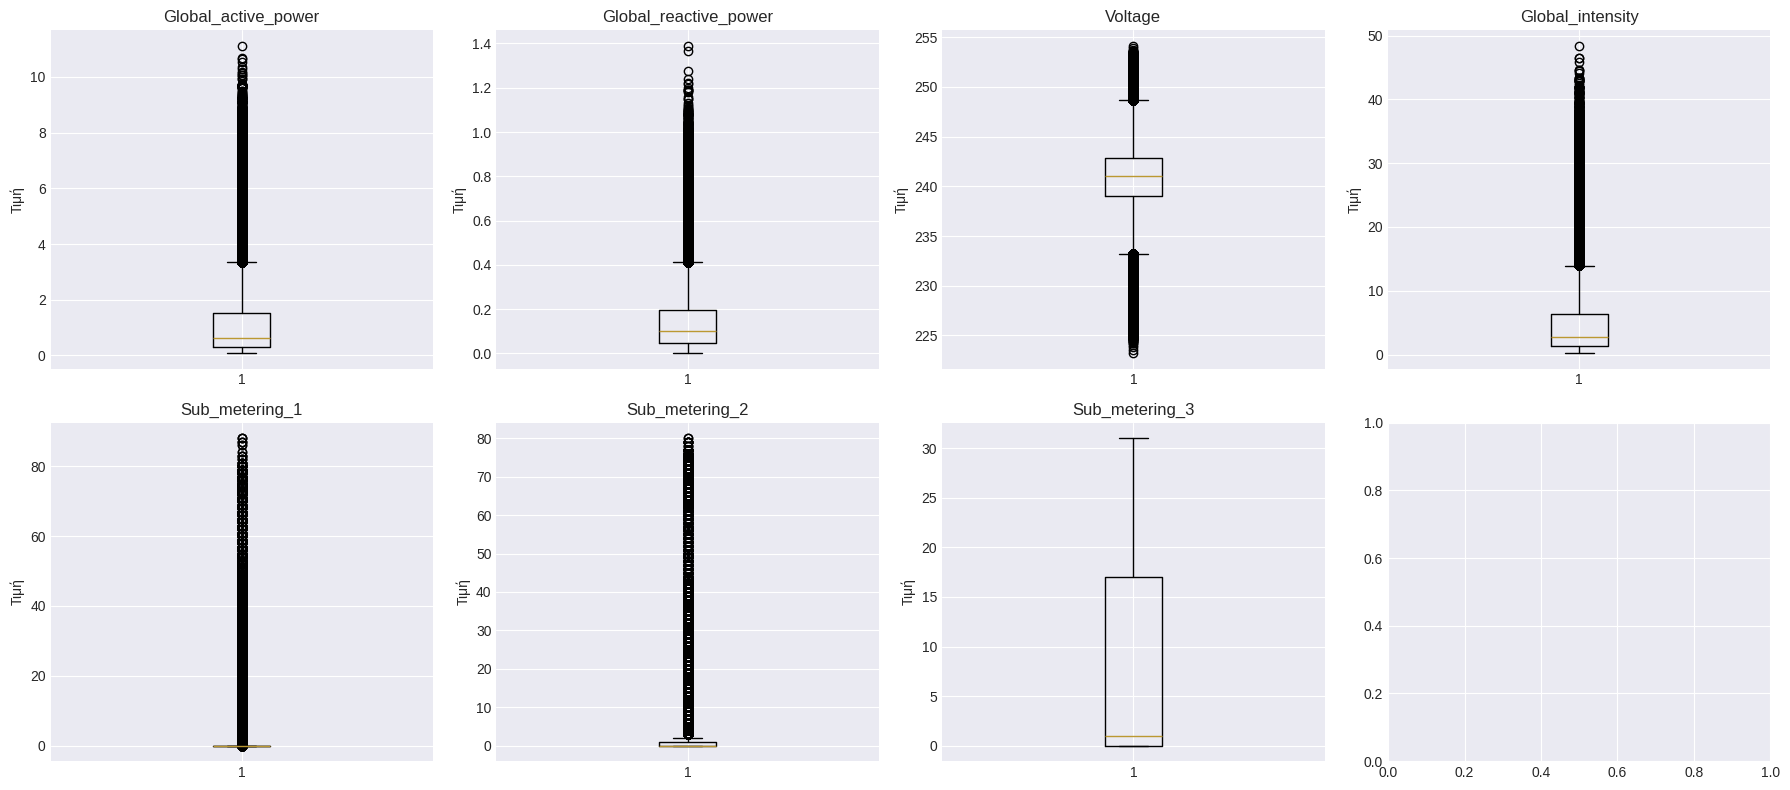

       Global_active_power  Global_reactive_power       Voltage  \
count         2.075259e+06           2.075259e+06  2.075259e+06   
mean          1.090264e+00           1.236483e-01  2.408328e+02   
std           1.052621e+00           1.124204e-01  3.237740e+00   
min           7.600000e-02           0.000000e+00  2.232000e+02   
25%           3.100000e-01           4.800000e-02  2.389900e+02   
50%           6.140000e-01           1.000000e-01  2.410000e+02   
75%           1.528000e+00           1.940000e-01  2.428700e+02   
max           1.112200e+01           1.390000e+00  2.541500e+02   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count      2.075259e+06    2.075259e+06    2.075259e+06    2.075259e+06  
mean       4.621416e+00    1.109489e+00    1.289177e+00    6.442334e+00  
std        4.424331e+00    6.115853e+00    5.786559e+00    8.415888e+00  
min        2.000000e-01    0.000000e+00    0.000000e+00    0.000000e+00  
25%        1.400000e+00   

In [20]:
# Οπτικοποίηση κατανομών πριν τον καθαρισμό
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for idx, col in enumerate(df.columns):
    axes[idx].boxplot(df[col].dropna())
    axes[idx].set_title(col)
    axes[idx].set_ylabel('Τιμή')

plt.tight_layout()
plt.savefig('../results/distributions_before_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

# Στατιστικά
print(df.describe())

In [21]:
# Εντοπισμός outliers με IQR method
def detect_outliers_iqr(df, columns, multiplier=1.5):
    outliers_dict = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_dict[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
    
    return outliers_dict

# Εφαρμογή για αριθμητικές στήλες
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outliers_info = detect_outliers_iqr(df, numeric_cols)

print("Outliers ανά στήλη:")
for col, info in outliers_info.items():
    print(f"\n{col}:")
    print(f"  Πλήθος: {info['count']}")
    print(f"  Ποσοστό: {info['percentage']:.2f}%")
    print(f"  Όρια: [{info['lower_bound']:.2f}, {info['upper_bound']:.2f}]")

Outliers ανά στήλη:

Global_active_power:
  Πλήθος: 95236
  Ποσοστό: 4.59%
  Όρια: [-1.52, 3.35]

Global_reactive_power:
  Πλήθος: 40481
  Ποσοστό: 1.95%
  Όρια: [-0.17, 0.41]

Voltage:
  Πλήθος: 52191
  Ποσοστό: 2.51%
  Όρια: [233.17, 248.69]

Global_intensity:
  Πλήθος: 100977
  Ποσοστό: 4.87%
  Όρια: [-6.10, 13.90]

Sub_metering_1:
  Πλήθος: 172246
  Ποσοστό: 8.30%
  Όρια: [0.00, 0.00]

Sub_metering_2:
  Πλήθος: 77156
  Ποσοστό: 3.72%
  Όρια: [-1.50, 2.50]

Sub_metering_3:
  Πλήθος: 0
  Ποσοστό: 0.00%
  Όρια: [-25.50, 42.50]


In [22]:
# Capping outliers αντί για αφαίρεση (διατηρούμε τα δεδομένα)
def cap_outliers(df, columns, multiplier=1.5):
    df_capped = df.copy()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Cap values
        df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
    
    return df_capped

# Εφαρμογή capping (προαιρετικό - μπορείς να το ενεργοποιήσεις αν χρειάζεται)
# df = cap_outliers(df, numeric_cols, multiplier=3.0)
print("Outliers διατηρήθηκαν (αληθινές μετρήσεις)")

Outliers διατηρήθηκαν (αληθινές μετρήσεις)


## 3. Feature Engineering

### 3.1 Temporal Features (Χρονικά Χαρακτηριστικά)

In [23]:
# Εξαγωγή χρονικών χαρακτηριστικών
df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek  # 0=Δευτέρα, 6=Κυριακή
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Year'] = df.index.year
df['DayOfYear'] = df.index.dayofyear

# Εργάσιμη/Σαββατοκύριακο
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Εποχή
def get_season(month):
    if month in [12, 1, 2]:
        return 'Χειμώνας'
    elif month in [3, 4, 5]:
        return 'Άνοιξη'
    elif month in [6, 7, 8]:
        return 'Καλοκαίρι'
    else:
        return 'Φθινόπωρο'

df['Season'] = df['Month'].apply(get_season)

# Χρονική περίοδος ημέρας
def get_time_period(hour):
    if 6 <= hour < 12:
        return 'Πρωί'
    elif 12 <= hour < 18:
        return 'Απόγευμα'
    elif 18 <= hour < 22:
        return 'Βράδυ'
    else:
        return 'Νύχτα'

df['TimePeriod'] = df['Hour'].apply(get_time_period)

print("Χρονικά χαρακτηριστικά δημιουργήθηκαν!")
print(f"\nΠαράδειγμα:")
df[['Hour', 'DayOfWeek', 'IsWeekend', 'Season', 'TimePeriod']].head(10)

Χρονικά χαρακτηριστικά δημιουργήθηκαν!

Παράδειγμα:


,Hour,DayOfWeek,IsWeekend,Season,TimePeriod
DateTime,,,,,
2006-12-16 17:24:00,17,5,1,Χειμώνας,Απόγευμα
2006-12-16 17:25:00,17,5,1,Χειμώνας,Απόγευμα
2006-12-16 17:26:00,17,5,1,Χειμώνας,Απόγευμα
2006-12-16 17:27:00,17,5,1,Χειμώνας,Απόγευμα
2006-12-16 17:28:00,17,5,1,Χειμώνας,Απόγευμα
2006-12-16 17:29:00,17,5,1,Χειμώνας,Απόγευμα
2006-12-16 17:30:00,17,5,1,Χειμώνας,Απόγευμα
2006-12-16 17:31:00,17,5,1,Χειμώνας,Απόγευμα
2006-12-16 17:32:00,17,5,1,Χειμώνας,Απόγευμα


### 3.2 Aggregated Features (Συγκεντρωτικά Χαρακτηριστικά)

In [24]:
# Δημιουργία ημερήσιων aggregations
print("Δημιουργία ημερήσιων συγκεντρωτικών...")

# Ημερήσια δεδομένα
daily_df = df.resample('D').agg({
    'Global_active_power': ['sum', 'mean', 'max', 'min', 'std'],
    'Global_reactive_power': ['sum', 'mean'],
    'Voltage': ['mean', 'std'],
    'Global_intensity': ['mean', 'max'],
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
})

# Flatten column names
daily_df.columns = ['_'.join(col).strip() for col in daily_df.columns.values]

# Μετονομασία για ευκολία
daily_df.rename(columns={
    'Global_active_power_sum': 'Daily_total_power',
    'Global_active_power_mean': 'Daily_mean_power',
    'Global_active_power_max': 'Daily_peak_power',
    'Global_active_power_min': 'Daily_min_power',
    'Global_active_power_std': 'Daily_std_power',
}, inplace=True)

print(f"Ημερήσια δεδομένα: {daily_df.shape}")
daily_df.head()

Δημιουργία ημερήσιων συγκεντρωτικών...
Ημερήσια δεδομένα: (1442, 14)


,Daily_total_power,Daily_mean_power,Daily_peak_power,Daily_min_power,Daily_std_power,Global_reactive_power_sum,Global_reactive_power_mean,Voltage_mean,Voltage_std,Global_intensity_mean,Global_intensity_max,Sub_metering_1_sum,Sub_metering_2_sum,Sub_metering_3_sum
DateTime,,,,,,,,,,,,,,
2006-12-16,1209.176,3.053475,7.706,0.284,1.026338,34.922,0.088187,236.243763,2.922896,13.082828,33.2,0.0,546.0,4926.0
2006-12-17,3390.460,2.354486,7.064,0.206,1.205795,226.006,0.156949,240.087028,4.051467,9.999028,30.0,2033.0,4187.0,13341.0
2006-12-18,2203.826,1.530435,6.158,0.202,1.005074,161.792,0.112356,241.231694,3.719576,6.421667,27.0,1063.0,2621.0,14018.0
2006-12-19,1666.194,1.157079,7.840,0.194,1.237602,150.942,0.104821,241.999313,3.069492,4.926389,33.6,839.0,7602.0,6197.0
2006-12-20,2225.748,1.545658,5.988,0.202,1.320968,160.998,0.111804,242.308062,3.345704,6.467361,25.2,0.0,2648.0,14063.0


In [25]:
# Peak hour και nighttime usage
print("Υπολογισμός Peak hour και Nighttime usage...")

# Peak hours: 18:00-22:00
peak_hours = df[df['Hour'].between(18, 21)].resample('D')['Global_active_power'].sum()
daily_df['Peak_hour_power'] = peak_hours

# Nighttime: 22:00-06:00
nighttime = df[df['Hour'].isin([22, 23, 0, 1, 2, 3, 4, 5])].resample('D')['Global_active_power'].sum()
daily_df['Nighttime_usage'] = nighttime

# Morning: 06:00-12:00
morning = df[df['Hour'].between(6, 11)].resample('D')['Global_active_power'].sum()
daily_df['Morning_usage'] = morning

# Afternoon: 12:00-18:00
afternoon = df[df['Hour'].between(12, 17)].resample('D')['Global_active_power'].sum()
daily_df['Afternoon_usage'] = afternoon

print("Περίοδοι ημέρας υπολογίστηκαν!")
daily_df[['Daily_total_power', 'Peak_hour_power', 'Nighttime_usage', 
          'Morning_usage', 'Afternoon_usage']].head()

Υπολογισμός Peak hour και Nighttime usage...
Περίοδοι ημέρας υπολογίστηκαν!


,Daily_total_power,Peak_hour_power,Nighttime_usage,Morning_usage,Afternoon_usage
DateTime,,,,,
2006-12-16,1209.176,801.448,255.704,NaN,152.024
2006-12-17,3390.460,780.466,878.974,807.772,923.248
2006-12-18,2203.826,614.240,347.398,578.608,663.580
2006-12-19,1666.194,505.812,213.834,650.252,296.296
2006-12-20,2225.748,798.420,468.320,630.964,328.044


In [26]:
# Προσθήκη χρονικών features στα ημερήσια δεδομένα
daily_df['DayOfWeek'] = daily_df.index.dayofweek
daily_df['IsWeekend'] = (daily_df['DayOfWeek'] >= 5).astype(int)
daily_df['Month'] = daily_df.index.month
daily_df['Season'] = daily_df['Month'].apply(get_season)
daily_df['DayOfYear'] = daily_df.index.dayofyear

print("Χρονικά features προστέθηκαν στα ημερήσια δεδομένα!")
print(f"\nΣτήλες ημερήσιων δεδομένων: {list(daily_df.columns)}")

Χρονικά features προστέθηκαν στα ημερήσια δεδομένα!

Στήλες ημερήσιων δεδομένων: ['Daily_total_power', 'Daily_mean_power', 'Daily_peak_power', 'Daily_min_power', 'Daily_std_power', 'Global_reactive_power_sum', 'Global_reactive_power_mean', 'Voltage_mean', 'Voltage_std', 'Global_intensity_mean', 'Global_intensity_max', 'Sub_metering_1_sum', 'Sub_metering_2_sum', 'Sub_metering_3_sum', 'Peak_hour_power', 'Nighttime_usage', 'Morning_usage', 'Afternoon_usage', 'DayOfWeek', 'IsWeekend', 'Month', 'Season', 'DayOfYear']


### 3.3 Οπτικοποίηση Features

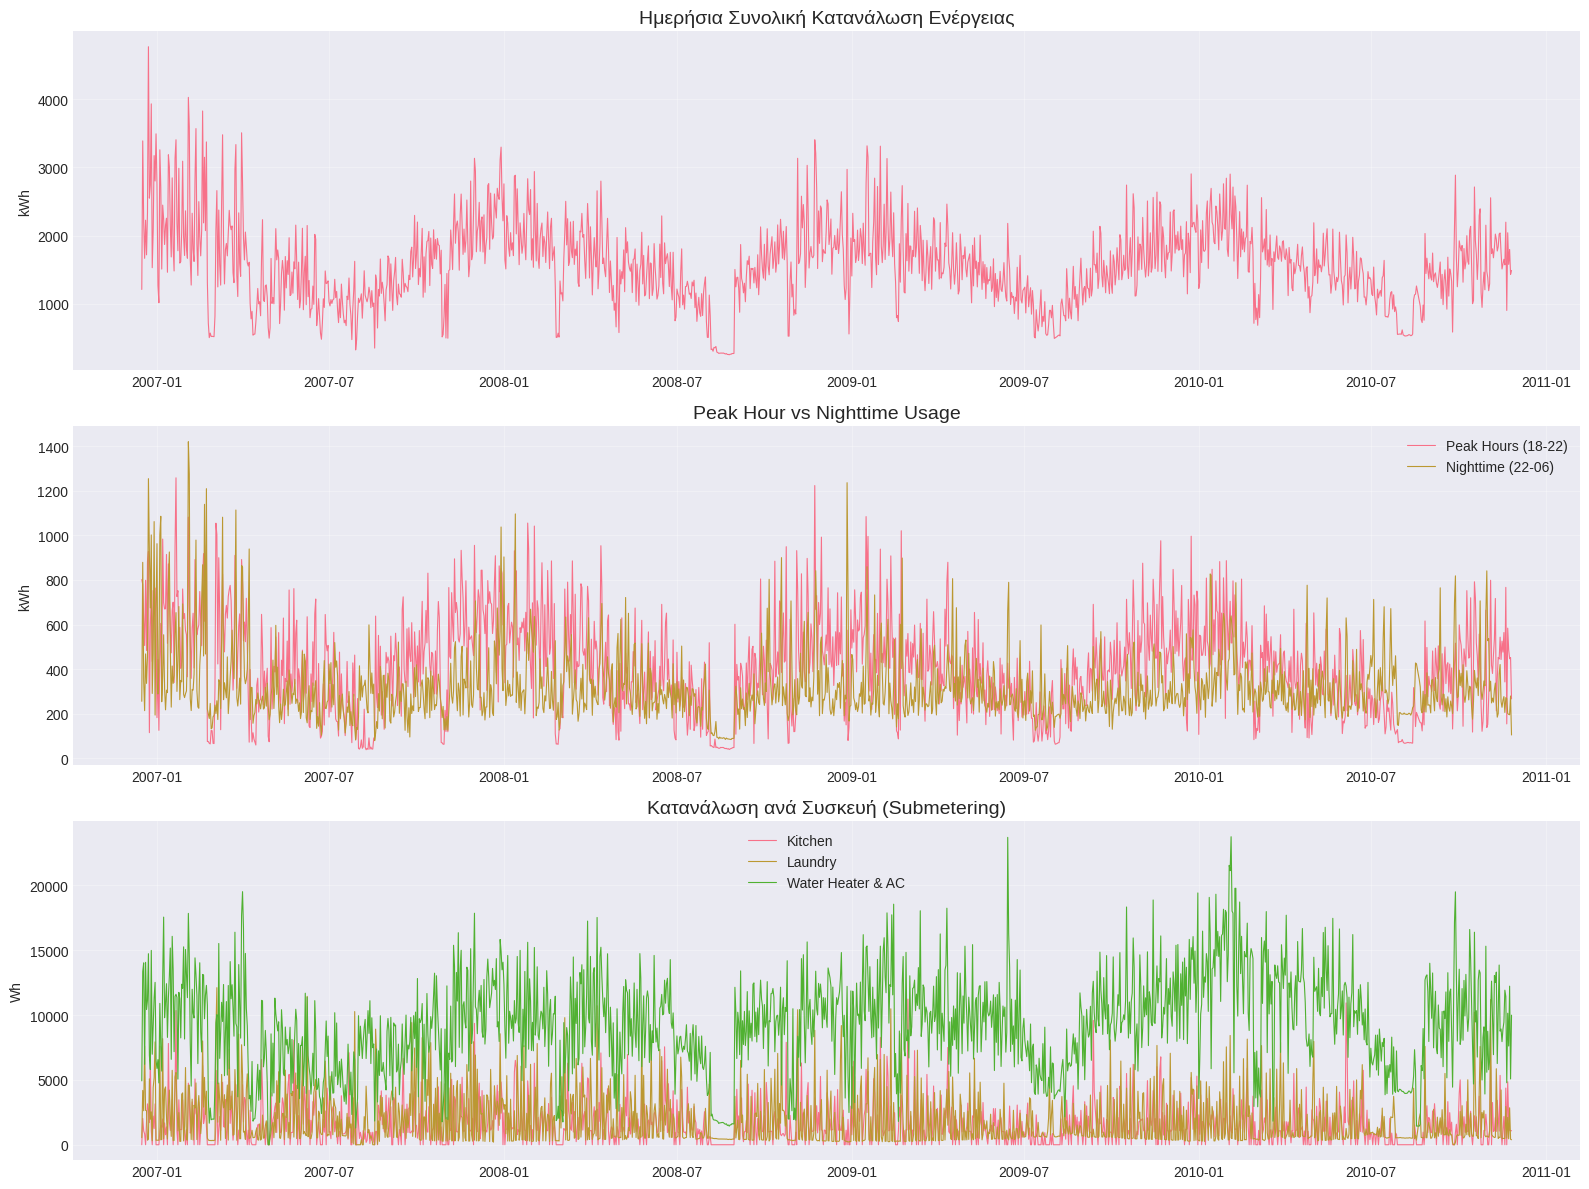

In [27]:
# Οπτικοποίηση ημερήσιας κατανάλωσης
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Συνολική ημερήσια κατανάλωση
axes[0].plot(daily_df.index, daily_df['Daily_total_power'], linewidth=0.8)
axes[0].set_title('Ημερήσια Συνολική Κατανάλωση Ενέργειας', fontsize=14)
axes[0].set_ylabel('kWh')
axes[0].grid(True, alpha=0.3)

# Peak vs Nighttime
axes[1].plot(daily_df.index, daily_df['Peak_hour_power'], label='Peak Hours (18-22)', linewidth=0.8)
axes[1].plot(daily_df.index, daily_df['Nighttime_usage'], label='Nighttime (22-06)', linewidth=0.8)
axes[1].set_title('Peak Hour vs Nighttime Usage', fontsize=14)
axes[1].set_ylabel('kWh')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Sub-metering
axes[2].plot(daily_df.index, daily_df['Sub_metering_1_sum'], label='Kitchen', linewidth=0.8)
axes[2].plot(daily_df.index, daily_df['Sub_metering_2_sum'], label='Laundry', linewidth=0.8)
axes[2].plot(daily_df.index, daily_df['Sub_metering_3_sum'], label='Water Heater & AC', linewidth=0.8)
axes[2].set_title('Κατανάλωση ανά Συσκευή (Submetering)', fontsize=14)
axes[2].set_ylabel('Wh')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/daily_consumption_overview.png', dpi=300, bbox_inches='tight')
plt.show()

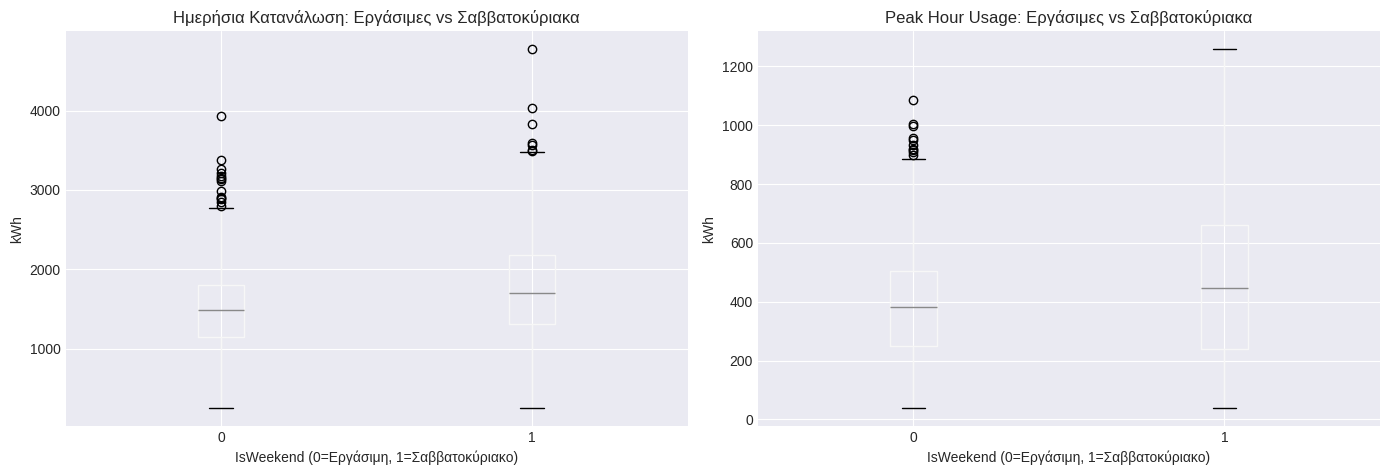


Μέση κατανάλωση:
IsWeekend
0    1493.288832
1    1758.477720
Name: Daily_total_power, dtype: float64


In [28]:
# Box plots για εργάσιμες vs Σαββατοκύριακα
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Daily total power
daily_df.boxplot(column='Daily_total_power', by='IsWeekend', ax=axes[0])
axes[0].set_title('Ημερήσια Κατανάλωση: Εργάσιμες vs Σαββατοκύριακα')
axes[0].set_xlabel('IsWeekend (0=Εργάσιμη, 1=Σαββατοκύριακο)')
axes[0].set_ylabel('kWh')

# Peak hour power
daily_df.boxplot(column='Peak_hour_power', by='IsWeekend', ax=axes[1])
axes[1].set_title('Peak Hour Usage: Εργάσιμες vs Σαββατοκύριακα')
axes[1].set_xlabel('IsWeekend (0=Εργάσιμη, 1=Σαββατοκύριακο)')
axes[1].set_ylabel('kWh')

plt.suptitle('')
plt.tight_layout()
plt.savefig('../results/weekday_vs_weekend.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nΜέση κατανάλωση:")
print(daily_df.groupby('IsWeekend')['Daily_total_power'].mean())

## 4. Κανονικοποίηση

Θα κανονικοποιήσουμε τα αριθμητικά χαρακτηριστικά για χρήση σε ML αλγορίθμους.

In [29]:
# Επιλογή χαρακτηριστικών προς κανονικοποίηση
features_to_normalize = [
    'Daily_total_power', 'Daily_mean_power', 'Daily_peak_power',
    'Daily_min_power', 'Daily_std_power',
    'Global_reactive_power_sum', 'Global_reactive_power_mean',
    'Voltage_mean', 'Voltage_std',
    'Global_intensity_mean', 'Global_intensity_max',
    'Sub_metering_1_sum', 'Sub_metering_2_sum', 'Sub_metering_3_sum',
    'Peak_hour_power', 'Nighttime_usage', 'Morning_usage', 'Afternoon_usage'
]

# Αφαίρεση NaN πριν την κανονικοποίηση
daily_df_clean = daily_df.dropna()
print(f"Δεδομένα μετά την αφαίρεση NaN: {daily_df_clean.shape}")

# StandardScaler
scaler_standard = StandardScaler()
daily_df_standard = daily_df_clean.copy()
daily_df_standard[features_to_normalize] = scaler_standard.fit_transform(
    daily_df_clean[features_to_normalize]
)

# MinMaxScaler
scaler_minmax = MinMaxScaler()
daily_df_minmax = daily_df_clean.copy()
daily_df_minmax[features_to_normalize] = scaler_minmax.fit_transform(
    daily_df_clean[features_to_normalize]
)

print("\nΚανονικοποίηση ολοκληρώθηκε!")
print(f"Διαστάσεις normalized data: {daily_df_standard.shape}")

Δεδομένα μετά την αφαίρεση NaN: (1441, 23)

Κανονικοποίηση ολοκληρώθηκε!
Διαστάσεις normalized data: (1441, 23)


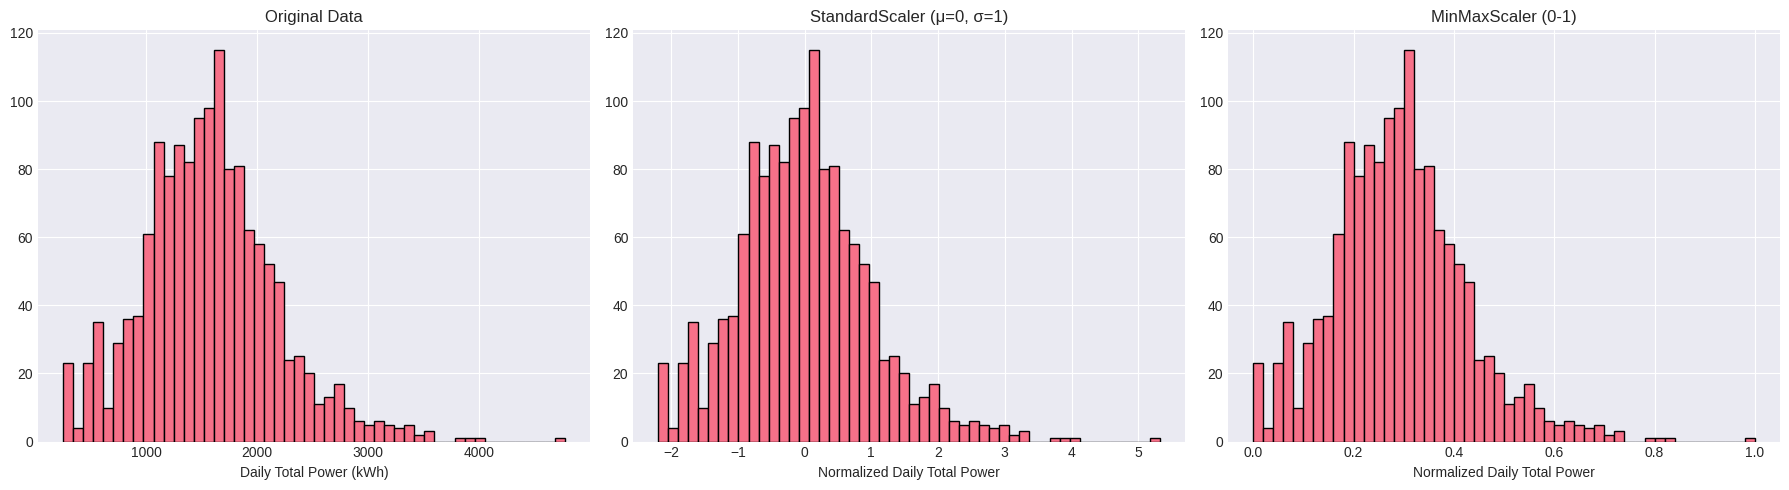

In [30]:
# Σύγκριση πριν/μετά την κανονικοποίηση
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original
daily_df_clean['Daily_total_power'].hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Daily Total Power (kWh)')

# StandardScaler
daily_df_standard['Daily_total_power'].hist(bins=50, ax=axes[1], edgecolor='black')
axes[1].set_title('StandardScaler (μ=0, σ=1)')
axes[1].set_xlabel('Normalized Daily Total Power')

# MinMaxScaler
daily_df_minmax['Daily_total_power'].hist(bins=50, ax=axes[2], edgecolor='black')
axes[2].set_title('MinMaxScaler (0-1)')
axes[2].set_xlabel('Normalized Daily Total Power')

plt.tight_layout()
plt.savefig('../results/normalization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Αποθήκευση Καθαρών Δεδομένων

Αποθηκεύουμε τα δεδομένα σε διάφορες μορφές για μελλοντική χρήση.

In [31]:
# Αποθήκευση δεδομένων λεπτού (minute-level)
print("Αποθήκευση minute-level data...")
df.to_csv('../data/household_power_cleaned_minute.csv')
print("✓ Αποθηκεύτηκε: household_power_cleaned_minute.csv")

# Αποθήκευση ημερήσιων δεδομένων (raw)
print("\nΑποθήκευση daily data (unnormalized)...")
daily_df_clean.to_csv('../data/household_power_daily_clean.csv')
print("✓ Αποθηκεύτηκε: household_power_daily_clean.csv")

# Αποθήκευση normalized data (StandardScaler)
print("\nΑποθήκευση normalized data (StandardScaler)...")
daily_df_standard.to_csv('../data/household_power_daily_standard.csv')
print("✓ Αποθηκεύτηκε: household_power_daily_standard.csv")

# Αποθήκευση normalized data (MinMaxScaler)
print("\nΑποθήκευση normalized data (MinMaxScaler)...")
daily_df_minmax.to_csv('../data/household_power_daily_minmax.csv')
print("✓ Αποθηκεύτηκε: household_power_daily_minmax.csv")

Αποθήκευση minute-level data...
✓ Αποθηκεύτηκε: household_power_cleaned_minute.csv

Αποθήκευση daily data (unnormalized)...
✓ Αποθηκεύτηκε: household_power_daily_clean.csv

Αποθήκευση normalized data (StandardScaler)...
✓ Αποθηκεύτηκε: household_power_daily_standard.csv

Αποθήκευση normalized data (MinMaxScaler)...
✓ Αποθηκεύτηκε: household_power_daily_minmax.csv


In [32]:
# Αποθήκευση scalers για μελλοντική χρήση
print("Αποθήκευση scalers...")

with open('../data/scaler_standard.pkl', 'wb') as f:
    pickle.dump(scaler_standard, f)
print("✓ Αποθηκεύτηκε: scaler_standard.pkl")

with open('../data/scaler_minmax.pkl', 'wb') as f:
    pickle.dump(scaler_minmax, f)
print("✓ Αποθηκεύτηκε: scaler_minmax.pkl")

# Αποθήκευση λίστας features
with open('../data/feature_names.pkl', 'wb') as f:
    pickle.dump(features_to_normalize, f)
print("✓ Αποθηκεύτηκε: feature_names.pkl")

Αποθήκευση scalers...
✓ Αποθηκεύτηκε: scaler_standard.pkl
✓ Αποθηκεύτηκε: scaler_minmax.pkl
✓ Αποθηκεύτηκε: feature_names.pkl


## 6. Περίληψη

### Αποτελέσματα Προεπεξεργασίας

In [33]:
print("=" * 70)
print("ΠΕΡΙΛΗΨΗ ΠΡΟΕΠΕΞΕΡΓΑΣΙΑΣ")
print("=" * 70)

print(f"\n📊 ΔΕΔΟΜΕΝΑ:")
print(f"  • Αρχικές μετρήσεις: {len(df):,} (minute-level)")
print(f"  • Ημερήσιες εγγραφές: {len(daily_df_clean):,}")
print(f"  • Χρονικό εύρος: {df.index.min().date()} - {df.index.max().date()}")
print(f"  • Διάρκεια: {(df.index.max() - df.index.min()).days} ημέρες")

print(f"\n🔧 FEATURES:")
print(f"  • Συνολικά features (minute): {len(df.columns)}")
print(f"  • Συνολικά features (daily): {len(daily_df_clean.columns)}")
print(f"  • Normalized features: {len(features_to_normalize)}")

print(f"\n📁 ΑΠΟΘΗΚΕΥΜΕΝΑ ΑΡΧΕΙΑ:")
print(f"  • household_power_cleaned_minute.csv")
print(f"  • household_power_daily_clean.csv")
print(f"  • household_power_daily_standard.csv")
print(f"  • household_power_daily_minmax.csv")
print(f"  • scaler_standard.pkl")
print(f"  • scaler_minmax.pkl")
print(f"  • feature_names.pkl")

print(f"\n✅ Η προεπεξεργασία ολοκληρώθηκε επιτυχώς!")
print("=" * 70)

ΠΕΡΙΛΗΨΗ ΠΡΟΕΠΕΞΕΡΓΑΣΙΑΣ

📊 ΔΕΔΟΜΕΝΑ:
  • Αρχικές μετρήσεις: 2,075,259 (minute-level)
  • Ημερήσιες εγγραφές: 1,441
  • Χρονικό εύρος: 2006-12-16 - 2010-11-26
  • Διάρκεια: 1441 ημέρες

🔧 FEATURES:
  • Συνολικά features (minute): 16
  • Συνολικά features (daily): 23
  • Normalized features: 18

📁 ΑΠΟΘΗΚΕΥΜΕΝΑ ΑΡΧΕΙΑ:
  • household_power_cleaned_minute.csv
  • household_power_daily_clean.csv
  • household_power_daily_standard.csv
  • household_power_daily_minmax.csv
  • scaler_standard.pkl
  • scaler_minmax.pkl
  • feature_names.pkl

✅ Η προεπεξεργασία ολοκληρώθηκε επιτυχώς!


In [34]:
# Preview τελικών δεδομένων
print("\nPreview καθαρών ημερήσιων δεδομένων:")
print(daily_df_clean.head())

print("\nΣτατιστικά:")
print(daily_df_clean.describe())


Preview καθαρών ημερήσιων δεδομένων:
            Daily_total_power  Daily_mean_power  Daily_peak_power  \
DateTime                                                            
2006-12-17           3390.460          2.354486             7.064   
2006-12-18           2203.826          1.530435             6.158   
2006-12-19           1666.194          1.157079             7.840   
2006-12-20           2225.748          1.545658             5.988   
2006-12-21           1717.112          1.192439             5.854   

            Daily_min_power  Daily_std_power  Global_reactive_power_sum  \
DateTime                                                                  
2006-12-17            0.206         1.205795                    226.006   
2006-12-18            0.202         1.005074                    161.792   
2006-12-19            0.194         1.237602                    150.942   
2006-12-20            0.202         1.320968                    160.998   
2006-12-21            0.194 